**Check wether ARIMA input is diff or timeseries itself**

# Download data

In [108]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import yfinance as yf

In [115]:
spy_df=yf.download('SPY', interval='1wk')

[*********************100%***********************]  1 of 1 completed


In [116]:
spy_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-25,43.968750,43.968750,43.750000,43.937500,25.547968,1003200.0
1993-02-01,43.968750,45.093750,43.968750,44.968750,26.147606,2234800.0
1993-02-08,44.968750,45.125000,44.531250,44.593750,25.929567,1159800.0
1993-02-15,44.468750,44.468750,42.812500,43.562500,25.329924,998700.0
1993-02-22,43.687500,44.437500,43.468750,44.406250,25.820549,1024300.0
...,...,...,...,...,...,...
2022-05-16,399.980011,408.570007,380.540009,389.630005,389.630005,509269500.0
2022-05-23,392.829987,415.380005,386.959991,415.260010,415.260010,426273600.0
2022-05-30,413.549988,417.440002,406.929993,410.540009,410.540009,333963200.0


In [110]:
spy_df=spy_df[['Adj Close']]

In [111]:
spy_df.isna().sum()

Adj Close    117
dtype: int64

In [112]:
spy_df.dropna(inplace=True)

<ipython-input-112-4068d59c46a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_df.dropna(inplace=True)


In [113]:
spy_df.isna().sum()

Adj Close    0
dtype: int64

In [53]:
spy_df.describe()

,Adj Close
count,1532.000000
mean,131.502080
std,99.126150
min,25.329927
25%,71.503325
50%,94.101234
75%,174.600929
max,473.489044


# Analyse Data, find Stationnary

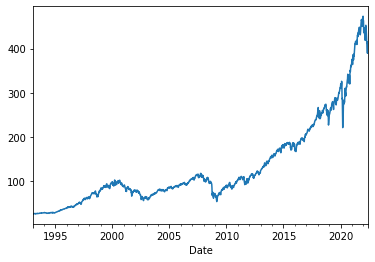

In [54]:
spy_df['Adj Close'].plot();

**As one can see the Timeseries is clearly not stationnary, try to work on the diffs?**

In [55]:
spy_df['diffs']=spy_df['Adj Close'].diff()

<ipython-input-55-7d57f1ac9ab6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_df['diffs']=spy_df['Adj Close'].diff()


In [56]:
spy_df.describe()['diffs']

count    1531.000000
mean        0.251464
std         3.865337
min       -39.132370
25%        -0.868084
50%         0.233727
75%         1.562687
max        29.152679
Name: diffs, dtype: float64

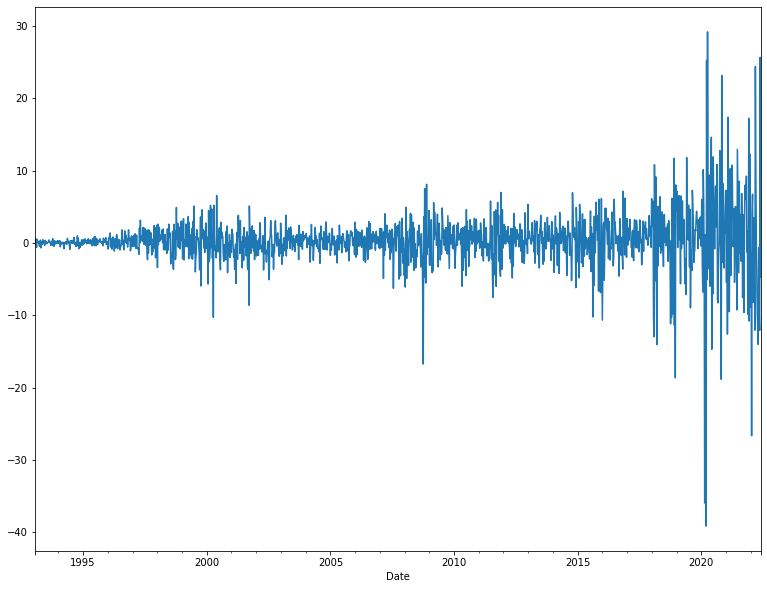

In [57]:
spy_df['diffs'].plot(figsize=(13,10));

**The diffs timeseries is somewhat stationnary, let's work with this**

# Let's build baselines

## The Always predict t-1

In [58]:
spy_df.shape

(1532, 2)

Let's make the last 350 the test set

In [59]:
testset=spy_df['diffs'].iloc[-350:]

In [60]:
trainset=spy_df['diffs'].iloc[:-350]

In [61]:
preds=testset.shift(1)

In [68]:
preds[0]=trainset[-1]

In [70]:
(preds.index==testset.index).all()

True

<AxesSubplot:xlabel='Date'>

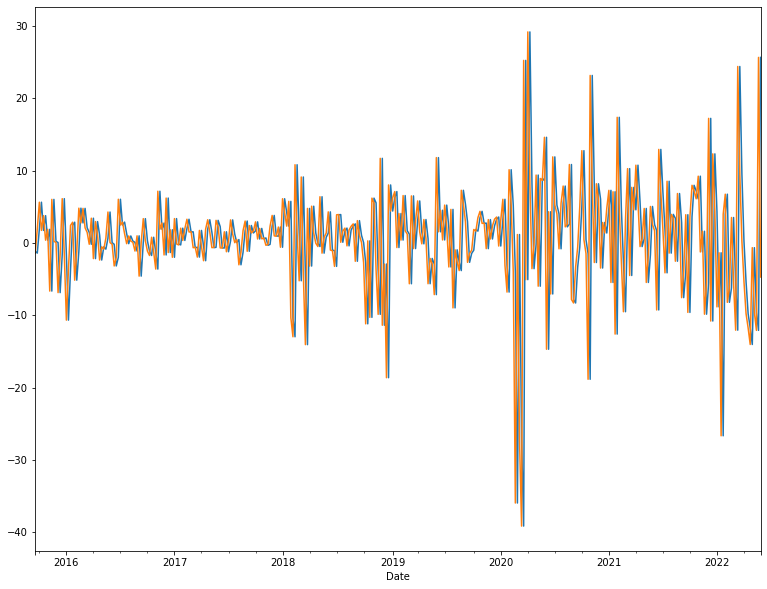

In [73]:
preds.plot(figsize=(13,10))
testset.plot()

In [74]:
from sklearn.metrics import mean_squared_error

In [88]:
rmse_baseline=mean_squared_error(testset,preds,squared=False)
rmse_baseline

10.431256470030018

# Autocorrelation 

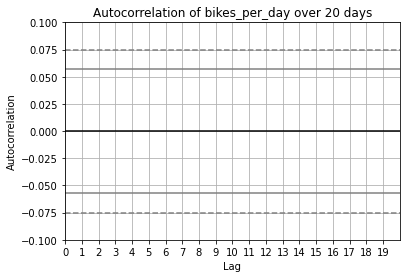

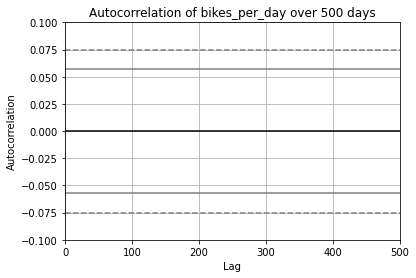

In [83]:
#bikes_per_day = bike_df.resample('d').sum()['Fremont Bridge Total']

plt.figure()
pd.plotting.autocorrelation_plot(trainset)
plt.xlim((0, 20))
plt.ylim((-.1, .1))
plt.xticks(range(20))
plt.title('Autocorrelation of bikes_per_day over 20 days')

plt.figure()
pd.plotting.autocorrelation_plot(trainset)
plt.xlim((0,500))
plt.ylim((-.1, .1))
plt.title('Autocorrelation of bikes_per_day over 500 days');

In [81]:
for i in range(1,30):
    print(i, trainset.autocorr(i))

1 -0.09965545098193453
2 0.06215253860565564
3 -0.05239455140111764
4 -0.03663615965383024
5 0.004460210994965802
6 0.034239329529126755
7 -0.084586630255859
8 0.05949232364733099
9 -0.015988931474551795
10 -0.016758500750479792
11 0.06122413101060543
12 -0.04415565688451747
13 0.009827468041082232
14 0.024997364028753525
15 0.05426358837977925
16 0.024906922752774053
17 0.03546460969705575
18 -0.01966843220726569
19 -0.03245006081643967
20 0.03341694478683782
21 0.02605481917670372
22 0.03582438001444982
23 0.009519337380993177
24 -0.013662604648153814
25 -0.010821135669651516
26 0.029667121112224474
27 -0.048966007607514316
28 -0.007890687413864669
29 -0.030247707835565657


In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [92]:
trainset.dropna(inplace=True)

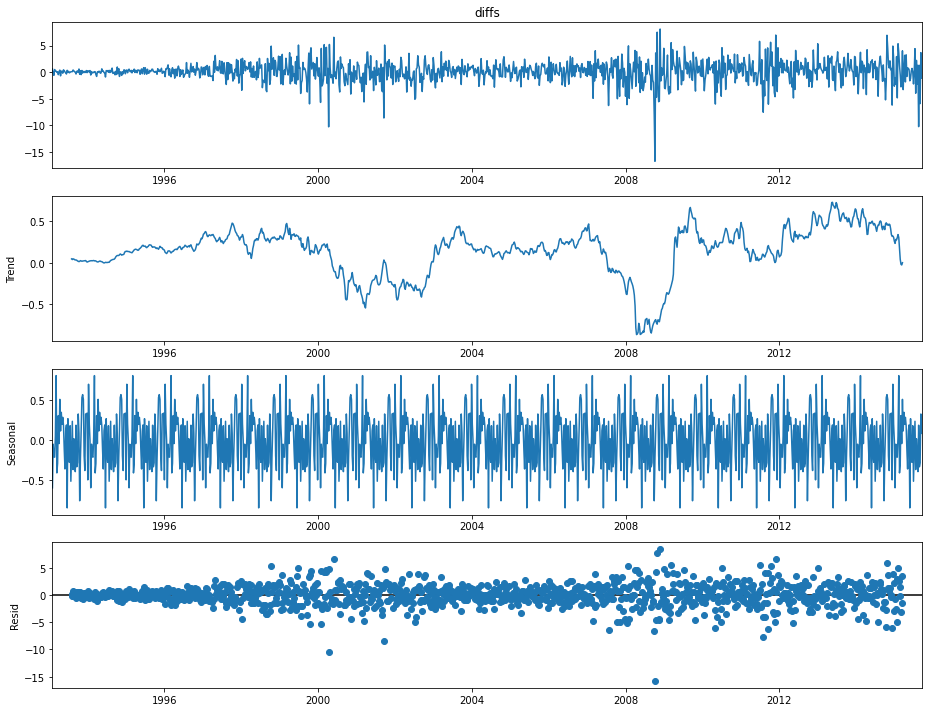

In [93]:
res=seasonal_decompose(trainset)
f=res.plot()
f.set_size_inches((13,10))
f.tight_layout();

In [94]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

C:\Users\chriq\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\chriq\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


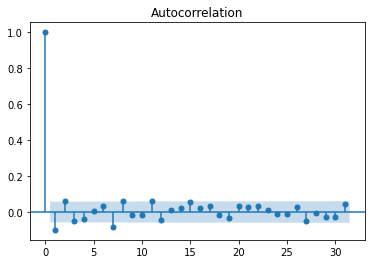

In [95]:
plot_acf(trainset);

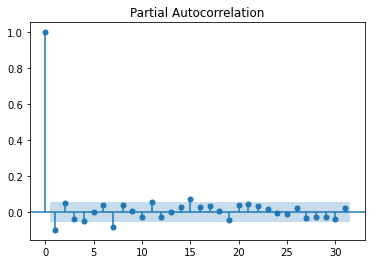

In [96]:
plot_pacf(trainset);

**There is no Autocorrelation what so ever that we can eventually use, it's not so clear the model based on assumptions such as autocorrelation will perform well**

# Arima

In [98]:
from statsmodels.tsa.arima.model import ARIMA

In [99]:
history=trainset.to_list()
predictions=[]
for t in range(len(testset)):
    model=ARIMA(history,order=(2,1,0))
    model_fit=model.fit()
    predictions.append(model_fit.forecast())
    history.append(testset[t])

In [100]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1530
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -4444.021
Date:                Tue, 07 Jun 2022   AIC                           8894.043
Time:                        12:21:50   BIC                           8910.040
Sample:                             0   HQIC                          8899.997
                               - 1530                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7410      0.010    -74.343      0.000      -0.761      -0.721
ar.L2         -0.3517      0.007    -49.508      0.000      -0.366      -0.338
sigma2        19.5836      0.216     90.764      0.000      19.161      20.006
===================================================================================
Ljung-Box (L1) (Q):                   5.76   Jarque-Bera (JB):             30010.71
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):              12.85   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [101]:
predictions=[p[0] for p in predictions]

In [102]:
predictions=pd.Series(data=predictions,index=testset.index)

In [104]:
ar_rmse=mean_squared_error(testset,predictions,squared=False)

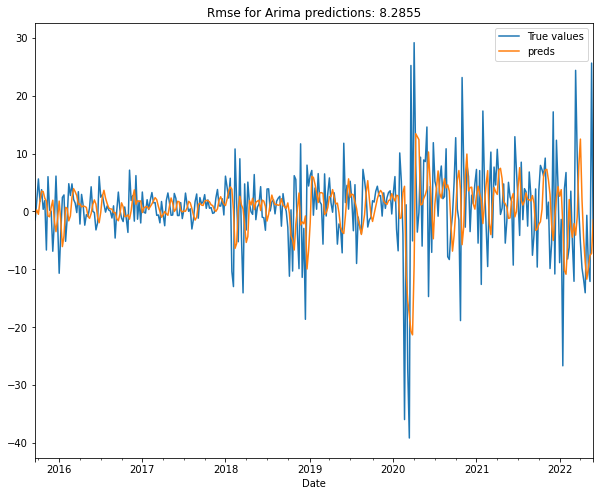

In [105]:
plt.figure(figsize=(10,8))
testset.plot(label='True values')
predictions.plot(label='preds')
plt.title(f'Rmse for Arima predictions: {ar_rmse:.4f}')
plt.legend();

In [107]:
rmse_baseline-ar_rmse

2.1457848827085506

This is an improvement,  but no real meaning